In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm, transforms
import geopandas as gpd
import locale
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.formula.api as smf
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

locale.setlocale(locale.LC_ALL, 'es_CL')

plt.style.use("seaborn")
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.grid'] = False
sns.set(font_scale=1.5)

BASE = "/media/giani/Gianicosas/Magister/Proyecto/"

# Datos

In [2]:
df = pd.read_csv(f"{BASE}work_data/matriz_desercion_4.csv.gz")
df.head(2)

/tmp/ipykernel_12660/527786335.py:1: DtypeWarning: Columns (17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{BASE}work_data/matriz_desercion_4.csv.gz")


,cat_periodo,codigo_unico,mrun,gen_alu,fec_nac_alu,anio_ing_carr_ori,tipo_inst_1,jornada,dur_estudio_carr,dur_proceso_tit,...,acreditada_carr,acreditada_inst,desertor_1,region_colegio,tipo_ensenanza_colegio,prom_notas_media,dependencia_colegio,fscu,gratuidad,beca
0,2015,I498S6C132J2V1,37.0,1,197808,2015,Centros de Formación Técnica,Vespertino,5,1.0,...,NO ACREDITADA,ACREDITADA,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,2015,I111S14C309J2V1,118.0,1,199102,2015,Institutos Profesionales,Vespertino,5,1.0,...,ACREDITADA,ACREDITADA,0.0,13,310.0,4.975,3.0,0.0,0.0,0.0


# Deserción

In [3]:
df["anio_desercion"] = df["cat_periodo"] + 1

In [4]:
porc_des = pd.DataFrame(df.groupby(["anio_desercion"])["desertor_1"].value_counts("%").rename("%") * 100).reset_index()
porc_des = porc_des[porc_des["desertor_1"]==1]
porc_des

,anio_desercion,desertor_1,%
1,2016,1.0,16.368109
3,2017,1.0,14.418847
5,2018,1.0,13.360973
7,2019,1.0,13.062208
9,2020,1.0,15.068913
11,2021,1.0,16.939409
13,2022,1.0,24.696973


# Beneficios

In [5]:
df.columns

Index(['cat_periodo', 'codigo_unico', 'mrun', 'gen_alu', 'fec_nac_alu',
       'anio_ing_carr_ori', 'tipo_inst_1', 'region_sede', 'valor_arancel',
       'area_conocimiento', 'acreditada_carr', 'acreditada_inst', 'desertor_1',
       'region_colegio', 'tipo_ensenanza_colegio', 'prom_notas_media',
       'dependencia_colegio', 'cant_becas', 'anio_desercion'],
      dtype='object')

In [21]:
cantidades = df[df["anio_desercion"] < 2021][
    ["anio_desercion", "mrun", "desertor_1", "jornada"]
].drop_duplicates().groupby(["anio_desercion", "jornada"]).agg({
    "mrun": pd.Series.nunique,
    "desertor_1": "sum"
}).reset_index()
cantidades.head()

,anio_desercion,jornada,mrun,desertor_1
0,2016,A Distancia,7558,1779.0
1,2016,Diurno,96626,11279.0
2,2016,Otro,65,25.0
3,2016,Semipresencial,1566,257.0
4,2016,Vespertino,79486,17002.0


In [23]:
cantidades["desertor_1_porc"] = [
    (d / cantidades[
        (cantidades["anio_desercion"] == a)
        & (cantidades["jornada"] == r)
    ]["mrun"].sum()) * 100 
    for a, d, r in zip(cantidades["anio_desercion"], cantidades["desertor_1"], cantidades["jornada"])
]

cantidades.head()

,anio_desercion,jornada,mrun,desertor_1,desertor_1_porc
0,2016,A Distancia,7558,1779.0,23.537973
1,2016,Diurno,96626,11279.0,11.672842
2,2016,Otro,65,25.0,38.461538
3,2016,Semipresencial,1566,257.0,16.411239
4,2016,Vespertino,79486,17002.0,21.389930


In [24]:
# # create the colorbar
norm = colors.Normalize(vmin=cantidades["desertor_1_porc"].min(), vmax=cantidades["desertor_1_porc"].max())
colores = cm.get_cmap('coolwarm', 256)
cbar = plt.cm.ScalarMappable(norm=norm, cmap=colores)

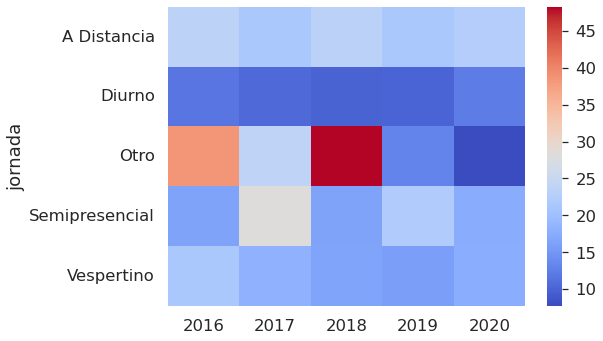

In [26]:
t_acc = cantidades[["anio_desercion", "jornada", "desertor_1_porc"]]
piv_acc = pd.pivot_table(
    t_acc, values="desertor_1_porc", index=["anio_desercion"], columns=["jornada"]
).reset_index().T
piv_acc = piv_acc.rename(columns=piv_acc.iloc[0].astype(int))[1:].reindex(index=cantidades['jornada'].unique())
sns.heatmap(piv_acc, cmap="coolwarm");

### Proporción matrículas únicas

In [27]:
df_s = df[df["anio_desercion"] < 2021].sort_values(
    by=["mrun", "codigo_unico", "desertor_1"], ascending=[False, False, False]
).drop_duplicates(subset=["mrun", "codigo_unico"], keep="first").copy()

cross_tab_prop = pd.crosstab(index=df_s['jornada'],
                             columns=df_s['desertor_1'],
                             normalize="index")

cross_tab = pd.crosstab(index=df_s['jornada'],
                        columns=df_s['desertor_1'])

print(df_s.shape)
cross_tab#527046, 505282

(1032311, 25)


desertor_1,0.0,1.0
jornada,,
A Distancia,59612,27740
Diurno,423680,105915
Otro,561,314
Semipresencial,8729,3549
Vespertino,283216,118995


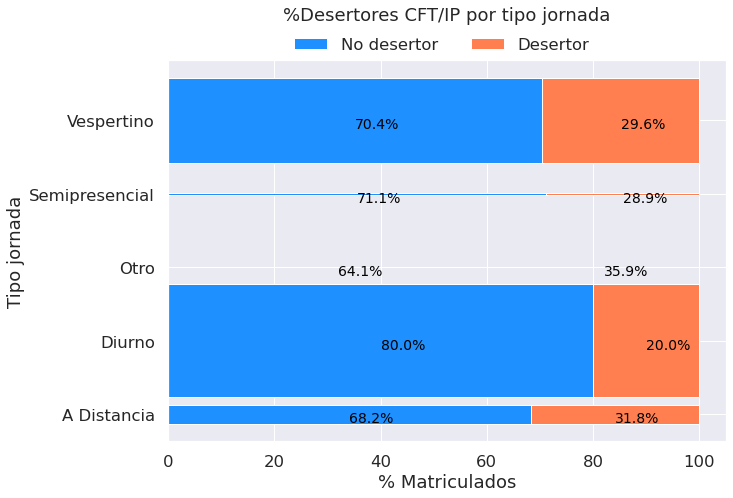

In [32]:
w = np.array(cross_tab.T.sum()/cross_tab.T.sum().sum()) * 3

f, ax = plt.subplots(figsize=(10,7))
plt.rcParams.update({'font.size': 15})

plt.title("%Desertores CFT/IP por tipo jornada", pad=40)

b1 = plt.barh(cross_tab_prop.reset_index()['jornada'],
                cross_tab_prop.reset_index()[0], 
                color="dodgerblue",
                height=w)

b2 = plt.barh(cross_tab_prop.reset_index()['jornada'],
                cross_tab_prop.reset_index()[1], 
                left=cross_tab_prop.reset_index()[0], 
                color="coral",
                height=w)
                
for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=14)
        
plt.xticks(np.arange(0, 1.2, 0.2), range(0, 120, 20))

ax.legend(['No desertor', 'Desertor'], loc ='upper left', ncol=2, bbox_to_anchor=(0.2,1.1));
plt.xlabel("% Matriculados");
plt.ylabel("Tipo jornada");

## Duración carrera

In [33]:
df_s.columns

Index(['cat_periodo', 'codigo_unico', 'mrun', 'gen_alu', 'fec_nac_alu',
       'anio_ing_carr_ori', 'tipo_inst_1', 'jornada', 'dur_estudio_carr',
       'dur_proceso_tit', 'region_sede', 'formato_valores', 'valor_arancel',
       'area_conocimiento', 'acreditada_carr', 'acreditada_inst', 'desertor_1',
       'region_colegio', 'tipo_ensenanza_colegio', 'prom_notas_media',
       'dependencia_colegio', 'fscu', 'gratuidad', 'beca', 'anio_desercion'],
      dtype='object')

Text(0.5, 0, 'Promedio')

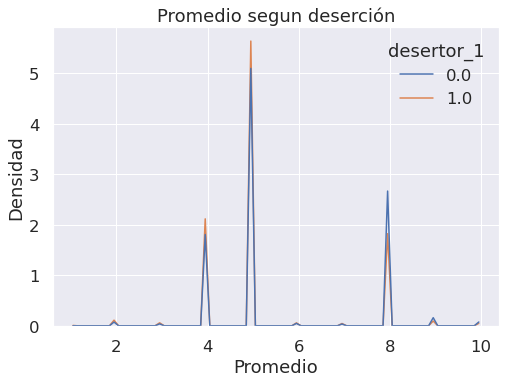

In [34]:
ax = sns.histplot(data=df_s, x="dur_estudio_carr", binwidth = 0.1, hue="desertor_1", element="poly",
                 stat="density", common_norm=False, fill=False)
ax.set_title("Promedio segun deserción")
ax.set_ylabel("Densidad")
ax.set_xlabel("Promedio")

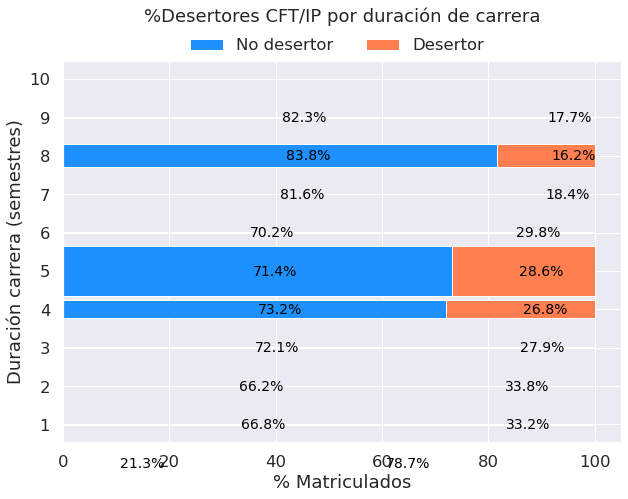

In [48]:
cross_tab_prop = pd.crosstab(index=df_s['dur_estudio_carr'],
                             columns=df_s['desertor_1'],
                             normalize="index")

cross_tab = pd.crosstab(index=df_s['dur_estudio_carr'],
                        columns=df_s['desertor_1'])

w = np.array(cross_tab.T.sum()/cross_tab.T.sum().sum()) * 2.5

f, ax = plt.subplots(figsize=(10,7))
plt.rcParams.update({'font.size': 15})

plt.title("%Desertores CFT/IP por duración de carrera", pad=40)

b1 = plt.barh(cross_tab_prop.reset_index()['dur_estudio_carr'],
                cross_tab_prop.reset_index()[0], 
                color="dodgerblue",
                height=w)

b2 = plt.barh(cross_tab_prop.reset_index()['dur_estudio_carr'],
                cross_tab_prop.reset_index()[1], 
                left=cross_tab_prop.reset_index()[0], 
                color="coral",
                height=w)
                
for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=14)
        
plt.xticks(np.arange(0, 1.2, 0.2), range(0, 120, 20))
plt.yticks(range(1, 11), range(1, 11))

ax.legend(['No desertor', 'Desertor'], loc ='upper left', ncol=2, bbox_to_anchor=(0.2,1.1));
plt.xlabel("% Matriculados");
plt.ylabel("Duración carrera (semestres)");

In [39]:
df_s['dur_estudio_carr'].value_counts()

5     539771
8     253657
4     194456
9      14881
2       8591
10      7103
6       5189
3       4494
7       3939
1        230
Name: dur_estudio_carr, dtype: int64